### MCAR, MNAR

***Missing Completely at Random, MCAR***: A variable is missing completely at random (MCAR) if the probability of being missing is the same for all the observations. When data is MCAR, there is absolutely no relationship between the data missing and any other values, observed or missing, within the dataset. In other words, those missing data points are a random subset of the data. There is nothing systematic going on that makes some data more likely to be missing than other.

 ***Missing Data Not At Random(MNAR)***: Systematic missing Values There is absolutely some relationship between the data missing and any other values, observed or missing, within the dataset.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
SEED = 32

In [2]:
PATH_DIR = '../../bases/titanic' 
FILE_NAME = 'train.csv'
FILE_PATH = os.path.join(PATH_DIR, FILE_NAME)

In [3]:
df = pd.read_csv(FILE_PATH)
trg = df.Survived
display(df.head(3))
print(df.shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


(891, 12)


In [6]:
display(trg.value_counts())

0    549
1    342
Name: Survived, dtype: int64

In [7]:
feats_isna = df.columns[np.where(df.isnull().any())[0]]
df[feats_isna].isna().mean()

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64

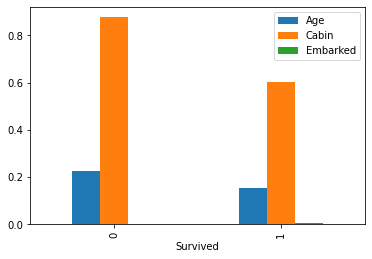

In [8]:
df_tmp = df[feats_isna].copy()
for feat in feats_isna:
    df_tmp[feat] = np.where(df_tmp[feat].isna(), 1, 0)
df_tmp.groupby(trg).mean().plot.bar()
plt.show()

Probably there is some relationship between variables (MCAR): Age and Survived. And we assume that Cabin variable is ***MAR***.

### Missing At Random (MAR)
#### All the techniques of handling missing values. 
***Numeric data.***
1. Mean/Median/Mode replacement
2. Random Sample Imputation
3. Capturing NAN values with a new feature (MNAR)
4. End of Distribution imputation
5. Arbitrary imputation
6. Nearest neighbors imputation

***Categorical data.***

7. Frequent Category Imputation


### Numeric data.

#### 1. Mean/Median/Mode replacement

In [9]:
usecols = ['Survived', 'Age']
df = pd.read_csv(FILE_PATH, usecols=usecols)

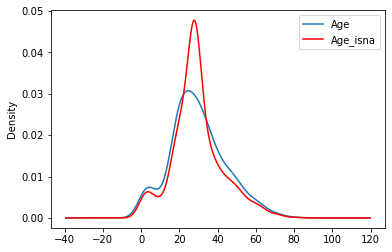

In [10]:
feat = 'Age'
df[feat+'_isna'] = df[feat].fillna(df[feat].median())
fig = plt.figure()
ax = fig.add_subplot(111)
df[feat].plot(kind='kde', ax=ax)
df[feat+'_isna'].plot(kind='kde', color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(handles=lines, labels=labels, loc='best')
plt.show()

***Advantages***
1. Easy to implement(Robust to outliers)
2. Faster way to obtain the complete dataset 

***Disadvantages***

3. Change or Distortion in the original variance
4. Impacts Correlation



#### 2.Random Sample Imputation¶

Aim: Random sample imputation consists of taking random observation from the dataset and we use this observation to replace the nan values

When should it be used? It assumes that the data are missing completely at random(MCAR)


In [11]:
usecols = ['Survived', 'Age']
df = pd.read_csv(FILE_PATH, usecols=usecols)

In [12]:
feat = 'Age'
df[feat+'_random'] = df[feat]
sample_random = df[feat].dropna().sample(df[feat].isna().sum(), random_state=SEED)
sample_random.index = df[df[feat].isna()].index
df.loc[df[feat].isna(), feat+'_random'] = sample_random

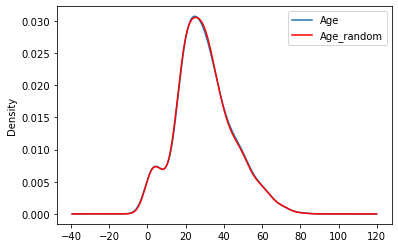

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
df[feat].plot(kind='kde', ax=ax)
df[feat+'_random'].plot(kind='kde', color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(handles=lines, labels=labels, loc='best')
plt.show()

##### Advantages
1. Easy to implement
2. There is less distortion in variance

##### Disadvantage
1. In every situation randomness wont work

#### 3. Capturing NAN values with a new feature
It works well if data is not missing completly at random

In [14]:
df = pd.read_csv(FILE_PATH, usecols=['Age'])

In [15]:
df['Age_nan'] = np.where(df.Age.isna(), 1, 0)
df.Age.fillna(df.Age.median(), inplace=True)

##### Advantages

1. Easy to implement
2. Captures the importance of missing values

##### Disadvantages
3. Creating Additional Features(Curse of Dimensionality)



#### End of distribution Imputation

<AxesSubplot:>

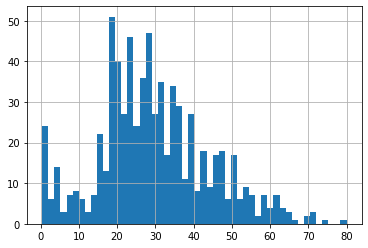

In [16]:
df = pd.read_csv(FILE_PATH, usecols=['Age', 'Survived'])
df.Age.hist(bins=50)

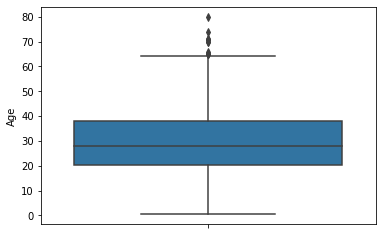

In [17]:
sns.boxplot(y='Age', data=df)
plt.show()

In [18]:
extreme = df.Age.mean() + 3*df.Age.std()
feat = 'Age'
df[feat+'_end_distribution'] = df[feat].fillna(extreme)

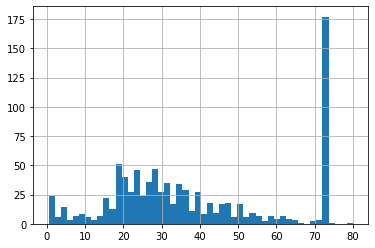

In [19]:
df[feat+'_end_distribution'].hist(bins=50)
plt.show()

#### Advantages
1. Easy to implement
2. Captures the importance of missingness if there is one

#### Disadvantage
3. Distorts the original distribution of the variable
4. If missingness is not important, it may mak the predictive power of the original variable by distorting its distribution
5. If the number of NA is big, it will mask true outliers in the distribution.
6. If the number of NA is small, the replaces NA may be considered an outlier and pre-processed in a subsequent step of feature engineering

#### 5. Arbitrary Value Imputation
It consists of replacing NAN by an arbitrary value.

In [20]:
df = pd.read_csv(FILE_PATH, usecols=['Age', 'Survived'])

43


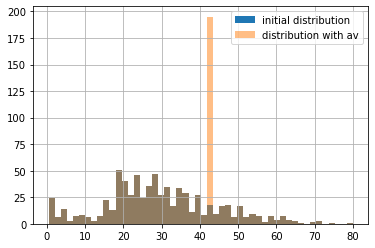

In [21]:
np.random.seed(SEED)
av = np.random.randint(df.Age.max()) # arbitrary value
print(av)
df['Age'].hist(bins=50, label='initial distribution')
df['Age'].fillna(av).hist(bins=50, label='distribution with av', alpha=0.5)
plt.legend()
plt.show()

##### Advantages

1. Easy to implement
2. Captures the importance of missingess if there is one

##### Disadvantages
1. Distorts the original distribution of the variable
2. If missingess is not important, it may mask the predictive power of the original variable by distorting its distribution
3. Hard to decide which value to use



#### 6. Nearest neighbors imputation

In [26]:
from sklearn.impute import KNNImputer
X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2, weights='uniform')
imputer.fit_transform(X)

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

### Missing values. Categorical data.

#### 7. Frequent Category Imputation

In [22]:
PATH_DIR = '../../bases/House Prices - Advanced Regression Techniques' 
FILE_NAME = 'train.csv'
FILE_PATH = os.path.join(PATH_DIR, FILE_NAME)

In [23]:
df = pd.read_csv(FILE_PATH, usecols=['BsmtQual','FireplaceQu','GarageType','SalePrice'])
print(df.shape)
df.head()

(1460, 4)


,BsmtQual,FireplaceQu,GarageType,SalePrice
0,Gd,NaN,Attchd,208500
1,Gd,TA,Attchd,181500
2,Gd,TA,Attchd,223500
3,TA,Gd,Detchd,140000
4,Gd,TA,Attchd,250000


In [24]:
from sklearn.impute import SimpleImputer

feat = df.columns[0]
df1 = df.copy()

for feat in df.columns:
    most_frequent_category = df1[feat].mode().values[0]
    df1[feat].fillna(most_frequent_category, inplace=True)
    

df2 = df.copy()
df2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df)
(df1.values == df2).all()

True